In [2]:
import torch

import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual

import os

## Read the dataset

In [3]:
from dataloaders.germany_dataset import load_image_and_labels
from image_helpers import polygons_to_bounding_boxes, polygons_to_masks, mask_to_polygons
from torchvision.utils import draw_segmentation_masks, draw_bounding_boxes
from torchvision.tv_tensors import BoundingBoxes, Mask

In [4]:
def plot_image_and_mask(image, masks):
    # Convert images to uint8
    image = (image * 255).byte()
    
    # Convert masks to bool
    masks = masks.bool()
    
    # Draw the masks on the image
    image_with_masks = draw_segmentation_masks(image, masks)
    
    # Convert to PIL image
    image_with_masks = image_with_masks.permute(1, 2, 0).numpy()
    
    # Plot the image
    plt.imshow(image_with_masks)
    plt.show()
    

In [5]:
from dataloaders.solar_dk_dataset import SolarDKDataset
import torchvision.transforms.v2 as transforms

train_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/train"
validation_folder = "data/solardk_dataset_neurips_v2/gentofte_trainval/val"

transform = transforms.Compose(    [
        transforms.ToDtype(torch.float32),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = SolarDKDataset(train_folder, transform=transform)
validation_dataset = SolarDKDataset(validation_folder, transform=transform)

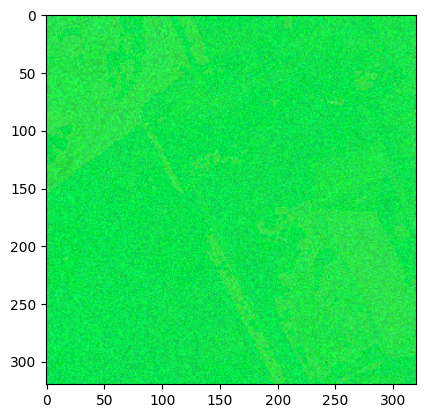

In [6]:
image, mask = train_dataset[10698]
plot_image_and_mask(image, mask)

### Load the dataset

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
validation_dataset = DataLoader(validation_dataset, batch_size=4, shuffle=False, num_workers=4)

### Train the model

In [8]:
import pytorch_lightning as pl
from models.base import BaseModel
from models.architectures.deep_lab import DeepLabModel
# from models.architectures.mask_rcnn import MaskRCNNModel
from models.architectures.unet import UNetModel

In [9]:
model = DeepLabModel(num_classes=1)
# model = UNetModel(n_channels=3, n_classes=1)

# model = MaskRCNNModel(num_classes=1)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

base_model = BaseModel(model, loss_fn, optimizer)
trainer = pl.Trainer(max_epochs=10, min_epochs=5)

/home/tue/20231335/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/home/tue/20231335/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'loss_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_fn'])`.
/home/tue/20231335/InterdisciplinaryProject/.venv/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/tue/20231335/InterdisciplinaryProject/.venv/li ...
GPU available: False, used: F

In [10]:
for image, label in train_dataloader:
    # Print the size of the image and label
    print(image.size(), label.size())  
    break

torch.Size([4, 3, 320, 320]) torch.Size([4, 3, 320, 320])


In [11]:
# trainer.fit(base_model, train_dataloaders=train_dataloader, val_dataloaders=validation_dataset)

In [15]:
from torchmetrics.functional.classification import dice

class CombinedBCEDiceLoss(torch.nn.Module):
    def __init__(self):
        super(CombinedBCEDiceLoss, self).__init__()
        self.bce = torch.nn.BCEWithLogitsLoss()

    def forward(self, y_hat, y):
        bce = self.bce(y_hat, y)
        y_hat = torch.sigmoid(y_hat)
        dice_loss = 1 - dice(y_hat, y.int())
        return bce + dice_loss

Dice Score: 0.8309534788131714
Jaccard Index: 0.7107958793640137
Accuracy: 0.9892480373382568
Precision: 0.9879518151283264
Recall: 0.7170111536979675
F1 Score: 0.8309534788131714


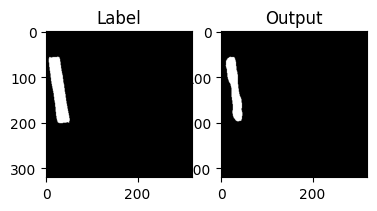

In [16]:
import torch
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
from PIL import Image

from torchmetrics.functional import jaccard_index, accuracy, precision, recall, f1_score, dice

test_folder = "data/solardk_dataset_neurips_v2/herlev_test/test"

model = BaseModel.load_from_checkpoint("lightning_logs/version_206025/checkpoints/epoch=149-step=25200.ckpt")

test_dataset = SolarDKDataset(test_folder)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Estimate the model on the test set
model.eval()
with torch.no_grad():
    image, label = next(iter(test_loader))
    
    idx = 1
    output = model(image)[idx]
    label  = label[idx]
    
    sigmoid_predictions = torch.sigmoid(output)
    output_predictions = (torch.sigmoid(output) > 0.1).float().squeeze()
    label = label[0].squeeze()
    
    print(f"Dice Score: {dice(output_predictions, label.int())}")
    print(f"Jaccard Index: {jaccard_index(output_predictions, label, task='binary')}")
    print(f"Accuracy: {accuracy(output_predictions, label, task='binary')}")
    print(f"Precision: {precision(output_predictions, label, task='binary')}")
    print(f"Recall: {recall(output_predictions, label, task='binary')}")
    print(f"F1 Score: {f1_score(output_predictions, label, task='binary')}")
    
    plt.subplot(1, 3, 2)
    plt.imshow(label, cmap="gray")
    plt.title("Label")
    
    plt.subplot(1, 3, 3)
    r = Image.fromarray(output_predictions.byte().cpu().numpy())
    plt.imshow(r, cmap="gray")
    plt.title("Output")
    
    plt.show()
    
        